Linear Regression: 23.50740312666734
Decision Tree: 11.538527012133072
Random Forest: 12.151967494460468
SVM: 20.15860973344364
Bayesian Ridge: 10.680389708923947


<Axes: title={'center': 'Bayesian Ridge'}, xlabel='time'>

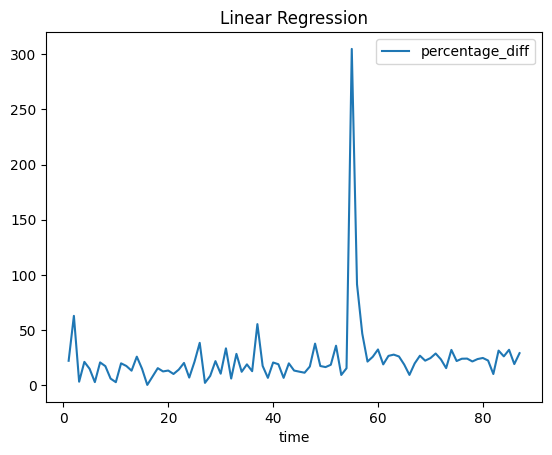

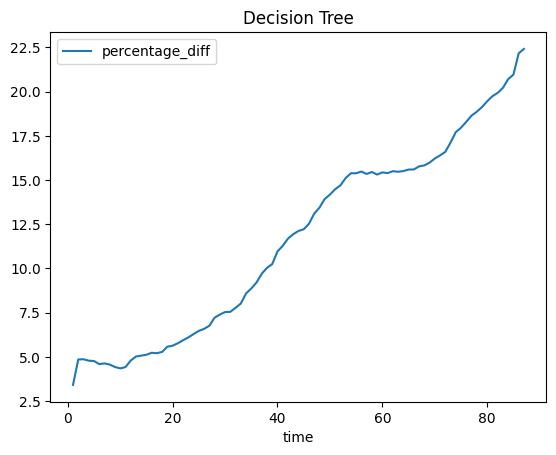

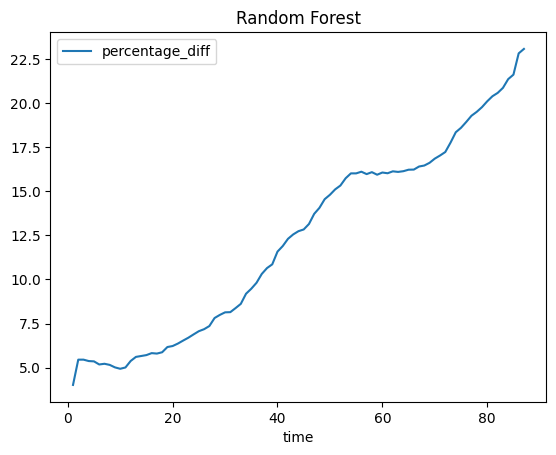

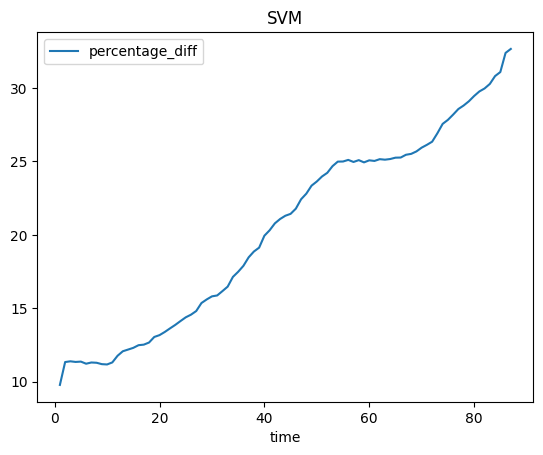

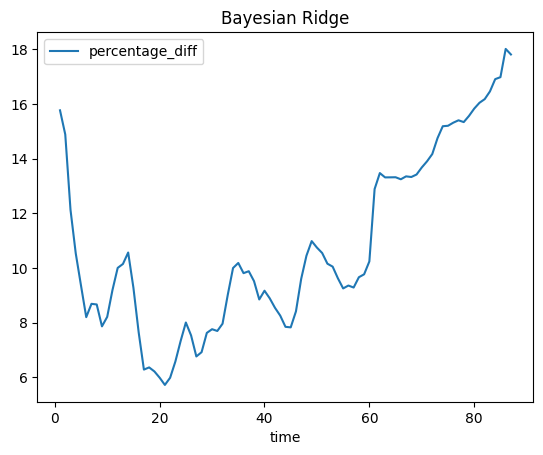

In [33]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge

N = 60  # Number of readings to include in the feature vector

# Split data into training and testing by last watering
def split_data(df, test_size=0.2):
    grouped = list(df.groupby('last_watered'))
    random.seed(42) 
    random.shuffle(grouped)
    split_index = int(len(grouped) * (1 - test_size))
    train_groups = grouped[:split_index]
    test_groups = grouped[split_index:]

    resampled_train_groups = []
    resampled_test_groups = []

    # Resample all groups to 30min intervals
    for _, group in train_groups:
        resampled_test_groups.append(group.resample('30min').mean())
    for _, group in test_groups:
        resampled_train_groups.append(group.resample('30min').mean())

    train_df = pd.concat(resampled_test_groups).reset_index(drop=True)
    test_df = pd.concat(resampled_train_groups).reset_index(drop=True)
    return train_df, test_df

# Creates time series windows and future soil moisture values to predict
def augment_data(train_df, columns, M):
    augmented_data = []
    grouped = train_df.groupby('last_watered')

    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        additional_series = {col: group[col].values for col in columns}
        
        for _ in range(len(time_series)):  # Augment multiple times per group
            window_end = random.randint(1,len(time_series)-1)
            window_data = time_series[:window_end]
            future_time = random.randint(window_end, len(time_series) - 1)
            
            # Pad the window data if it is shorter than N
            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')
            
            # Collect M points of each additional column data
            additional_values = {col: series[:window_end] for col, series in additional_series.items()}

            # Pad if shorter than M
            for col, values in additional_values.items():
                if len(values) < M:
                    additional_values[col] = np.pad(values, (M - len(values), 0), mode='edge')

            # We train on the time series of moisture, plus the current additional columns
            train_values = np.ndarray.tolist(window_data[:N])
            for col in columns:
                train_values.extend(additional_values[col][:M])

            augmented_data.append((train_values, future_time, time_series[future_time]))
    
    return augmented_data

def train_model(augmented_data, model=None):
    if model is None:
        model = LinearRegression()  # Using Linear Regression as a placeholder model

    X_train = []
    y_train = []
    
    for window_data, _, future_moisture in augmented_data:
        X_train.append(window_data)
        y_train.append(future_moisture)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    model.fit(X_train, y_train)
    return model

# Evaluate by percentage difference
def evaluate_model(model, test_df, columns, M):
    total_percentage_diff = 0
    grouped = test_df.groupby('last_watered')

    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        additional_series = {col: group[col].values for col in columns}

        for i in range(1, len(time_series)):
            window_data = time_series[max(0, i-N):i]
            
            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')
                
            # Collect corresponding additional data points
            additional_values = {col: series[max(0, i-M):i] for col, series in additional_series.items()}
            
            # Pad if shorter than M
            for col, values in additional_values.items():
                if len(values) < M:
                    additional_values[col] = np.pad(values, (M - len(values), 0), mode='edge')

            X_test = np.concatenate([window_data] + [additional_values[col] for col in columns]).reshape(1, -1)
            actual_soil_moisture = time_series[i]
            predicted_soil_moisture = model.predict(X_test)[0]
            percentage_diff = abs(actual_soil_moisture - predicted_soil_moisture) / actual_soil_moisture * 100
            total_percentage_diff += percentage_diff

    average_percentage_diff = total_percentage_diff / len(test_df)
    return average_percentage_diff

# Evaluate all points, returns the accuracy of different amounts of time into the future, as a df
def evaluate_model_over_time(model, test_df, columns, M):
    results = []
    grouped = test_df.groupby('last_watered')

    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        additional_series = {col: group[col].values for col in columns}

        for i in range(1, len(time_series)):
            window_data = time_series[max(0, i-N):i]

            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')

            # Collect corresponding additional data points
            additional_values = {col: series[max(0, i-M):i] for col, series in additional_series.items()}

            # Pad if shorter than M
            for col, values in additional_values.items():
                if len(values) < M:
                    additional_values[col] = np.pad(values, (M - len(values), 0), mode='edge')

            X_test = np.concatenate([window_data] + [additional_values[col] for col in columns]).reshape(1, -1)
            actual_soil_moisture = time_series[i]
            predicted_soil_moisture = model.predict(X_test)[0]
            percentage_diff = abs(actual_soil_moisture - predicted_soil_moisture) / actual_soil_moisture * 100
            results.append([i, percentage_diff])

    return pd.DataFrame(results, columns=['time', 'percentage_diff'])

# Example usage with a sample dataframe
df = pd.read_csv("palm_features.csv")
df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='ms')
df = df.set_index('time_stamp')

# Split the data into training and testing sets
train_df, test_df = split_data(df)

# Define columns and M value
columns = ["ext_temp", "humidity", "light"]
M = 0

# Augment the training data
augmented_data = augment_data(train_df, columns, M)

# Train models
model_lin = train_model(augmented_data, model=LinearRegression())
model_tree = train_model(augmented_data, model=DecisionTreeRegressor())
model_forest = train_model(augmented_data, model=RandomForestRegressor())
model_svm = train_model(augmented_data, model=SVR())
model_bayes = train_model(augmented_data, model=BayesianRidge())

# Evaluate the models
print(f"Linear Regression: {evaluate_model(model_lin, test_df, columns, M)}")
print(f"Decision Tree: {evaluate_model(model_tree, test_df, columns, M)}")
print(f"Random Forest: {evaluate_model(model_forest, test_df, columns, M)}")
print(f"SVM: {evaluate_model(model_svm, test_df, columns, M)}")
print(f"Bayesian Ridge: {evaluate_model(model_bayes, test_df, columns, M)}")

# Evaluate into the future and plot
results_lin = evaluate_model_over_time(model_lin, test_df, columns, M)
results_tree = evaluate_model_over_time(model_tree, test_df, columns, M)
results_forest = evaluate_model_over_time(model_forest, test_df, columns, M)
results_svm = evaluate_model_over_time(model_svm, test_df, columns, M)
results_bayes = evaluate_model_over_time(model_bayes, test_df, columns, M)

results_lin.plot(x='time', y='percentage_diff', title='Linear Regression')
results_tree.plot(x='time', y='percentage_diff', title='Decision Tree')
results_forest.plot(x='time', y='percentage_diff', title='Random Forest')
results_svm.plot(x='time', y='percentage_diff', title='SVM')
results_bayes.plot(x='time', y='percentage_diff', title='Bayesian Ridge')